<a href="https://colab.research.google.com/github/Armin-Abdollahi/Bone-Age-Estimation/blob/main/Bone_Age_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

In [3]:
# Load the labels
labels_path = '/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images/Label.csv'
labels = pd.read_csv(labels_path)

In [4]:
labels['Case ID'] = labels['Case ID'].apply(lambda x: str(x)+'.jpg')
labels.head()

,Case ID,Bone Age,Male,Location
0,1.jpg,0,False,Asian
1,2.jpg,0,False,Asian
2,3.jpg,0,False,Asian
3,4.jpg,0,False,Asian
4,5.jpg,0,False,Asian


In [5]:
# Ensure the 'Case ID' column is of type string
labels['Case ID'] = labels['Case ID'].astype(str)

In [6]:
# Create the image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
# Create the train and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images',
    x_col='Case ID',
    y_col='Bone Age',
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images',
    x_col='Case ID',
    y_col='Bone Age',
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    subset='validation'
)

Found 5915 validated image filenames.
Found 1478 validated image filenames.


In [8]:
# Define U-Net architecture
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottleneck
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv2)
    merge1 = concatenate([conv1, up1], axis=-1)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

    # Output layer
    output = Conv2D(1, (1, 1), activation='linear')(conv3)

    model = Model(inputs=inputs, outputs=output)
    return model

In [9]:
# Create the U-Net model
input_shape = (256, 256, 1)  # Adjust input shape based on your data
model = unet_model(input_shape)

In [10]:
# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [11]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_3[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 96)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 32)   │         27,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 1)    │             33 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,953 (398.25 KB)

 Trainable params: 101,953 (398.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 1837s 10s/step - accuracy: 0.0519 - loss: 44.6194 - mae: 5.5337 - val_accuracy: 0.0679 - val_loss: 26.4764 - val_mae: 4.3206
Epoch 2/10
  1/184 ━━━━━━━━━━━━━━━━━━━━ 57s 314ms/step - accuracy: 0.0938 - loss: 35.6049 - mae: 5.3264

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0938 - loss: 35.6049 - mae: 5.3264 - val_accuracy: 0.0000e+00 - val_loss: 27.0030 - val_mae: 4.5457
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.0498 - loss: 33.6331 - mae: 4.9666 - val_accuracy: 0.0679 - val_loss: 30.2878 - val_mae: 4.6792
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.0625 - loss: 36.3949 - mae: 5.4073 - val_accuracy: 0.0000e+00 - val_loss: 29.4173 - val_mae: 4.8337
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.0555 - loss: 31.0698 - mae: 4.8290 - val_accuracy: 0.0679 - val_loss: 27.3215 - val_mae: 4.4178
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.0625 - loss: 29.9129 - mae: 4.9265 - val_accuracy: 0.0000e+00 - val_loss: 26.0215 - val_mae: 4.5000
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.0515 - loss: 31.2139 - mae: 4.7952 - val_accuracy: 0.0679 - val_loss: 29.3012 - val_mae: 4.5979
Epoch 8/10
184/184

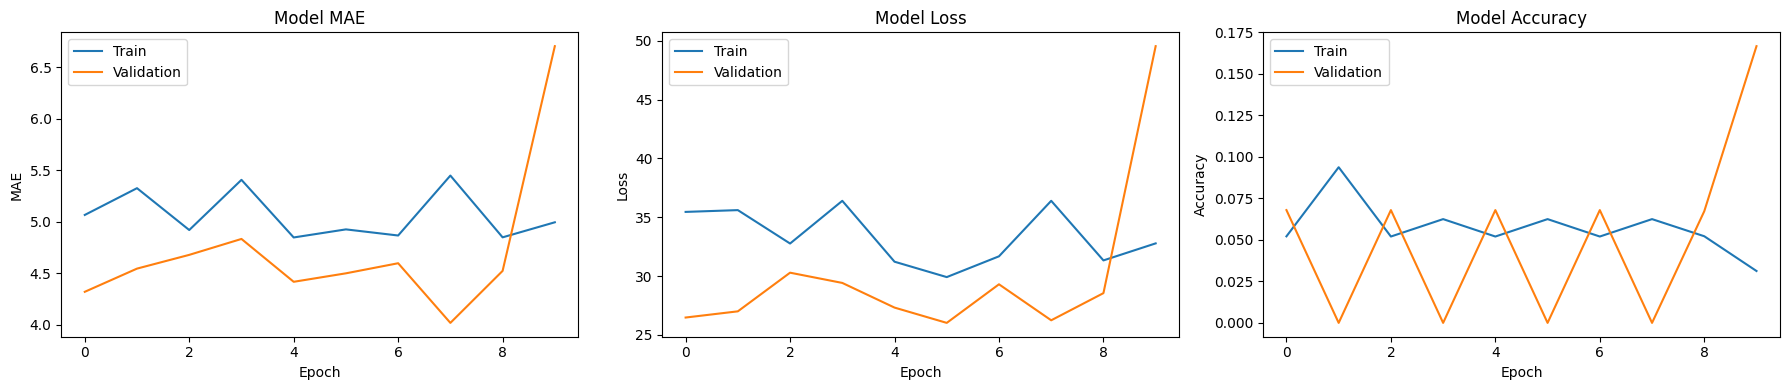

In [13]:
# Plot training & validation MAE values
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=15
)

In [ ]:
# Plot training & validation MAE values
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()